In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.dates as mdates

survey = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/survey_data/wave_1/w1_household_information_and_history.csv')

In [2]:
all_data = pd.DataFrame()
total = 0
for root, folder, files in os.walk('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/consumption_data/smart_meter/6hour_interval'):
    for file in files:
        if file.endswith('.csv'):
            file_path = os.path.join(root, file)
            data = pd.read_csv(file_path, low_memory=False)
            all_data = pd.concat([all_data, data], ignore_index=True)
            rows, cols = data.shape
            total = total + rows

#this notebook will be dealing with selected columns as below
all_data_filtered = all_data[['household_ID', 'DATE', 'TIME', 'TOTAL_IMPORT (kWh)', 'TOTAL_EXPORT (kWh)']].copy()

all_data_filtered['TIME'] = all_data_filtered['TIME'].str.extract(r'(\d{2}:\d{2}:\d{2})')

all_data_filtered['DATETIME'] = pd.to_datetime(all_data_filtered['DATE'] + ' ' + all_data_filtered['TIME'], errors='coerce')

### Time-recorded Density Graph

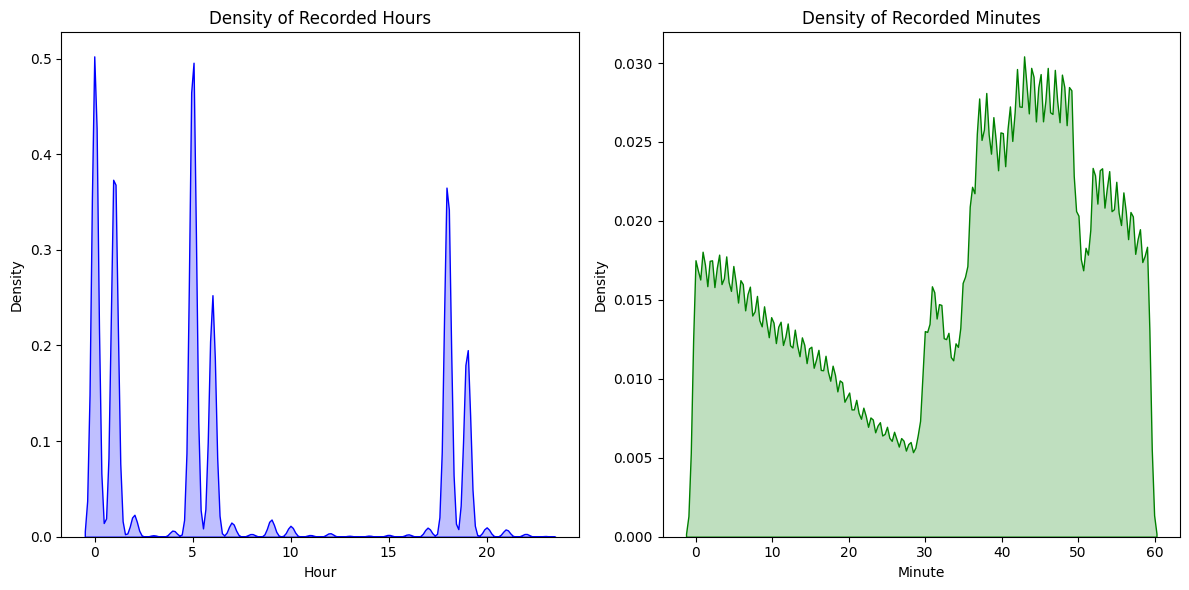

In [3]:
all_data_filtered['Hour'] = all_data_filtered['DATETIME'].dt.hour
all_data_filtered['Minute'] = all_data_filtered['DATETIME'].dt.minute

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.kdeplot(all_data_filtered['Hour'], fill=True, color='blue', bw_adjust=0.5)
plt.title('Density of Recorded Hours')
plt.xlabel('Hour')
plt.ylabel('Density')


plt.subplot(1, 2, 2)
sns.kdeplot(all_data_filtered['Minute'], fill=True, color='green', bw_adjust=0.5)
plt.title('Density of Recorded Minutes')
plt.xlabel('Minute')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

#### Based on the insights from the above density we are categorizing the time recorded as below

In [4]:
def categorize_time(time_str):
    hour = int(time_str.split(':')[0])
    
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 20:
        return 'evening'
    else:
        return 'night'

all_data_filtered['time_cat'] = all_data_filtered['TIME'].apply(categorize_time)
all_data_filtered['TOTAL_IMPORT (kWh)'] = pd.to_numeric(all_data_filtered['TOTAL_IMPORT (kWh)'], errors='coerce')
all_data_filtered['TOTAL_EXPORT (kWh)'] = pd.to_numeric(all_data_filtered['TOTAL_EXPORT (kWh)'], errors='coerce')

rows, cols = all_data_filtered.shape
print(f'total rows read : {total}')
print(f'total rows in the dataframe : {rows}')

total rows read : 4441793
total rows in the dataframe : 4441793


In [5]:
all_data_filtered = all_data_filtered[['household_ID', 'DATETIME', 'Hour', 'Minute','time_cat', 'TOTAL_IMPORT (kWh)', 'TOTAL_EXPORT (kWh)']].copy()
all_data_filtered.dropna(inplace=True)
all_data_filtered.isnull().sum()

household_ID          0
DATETIME              0
Hour                  0
Minute                0
time_cat              0
TOTAL_IMPORT (kWh)    0
TOTAL_EXPORT (kWh)    0
dtype: int64

In [6]:
'''
since each consumption point is a cumulative conusmption we need to substract every datapoint from 
its previous datapoint to get the exact consumption between the timestamps by considering houshold id
'''
# Important: sort the dataset before substracting  
all_data_filtered = all_data_filtered.sort_values(['household_ID', 'DATETIME'])

all_data_filtered[['TOTAL_IMPORT (kWh)', 'TOTAL_EXPORT (kWh)']] = (
    all_data_filtered.groupby('household_ID')[['TOTAL_IMPORT (kWh)', 'TOTAL_EXPORT (kWh)']].diff()
)

In [7]:
(all_data_filtered[['TOTAL_IMPORT (kWh)', 'TOTAL_EXPORT (kWh)']] < 0).sum()

TOTAL_IMPORT (kWh)    19418
TOTAL_EXPORT (kWh)    17479
dtype: int64

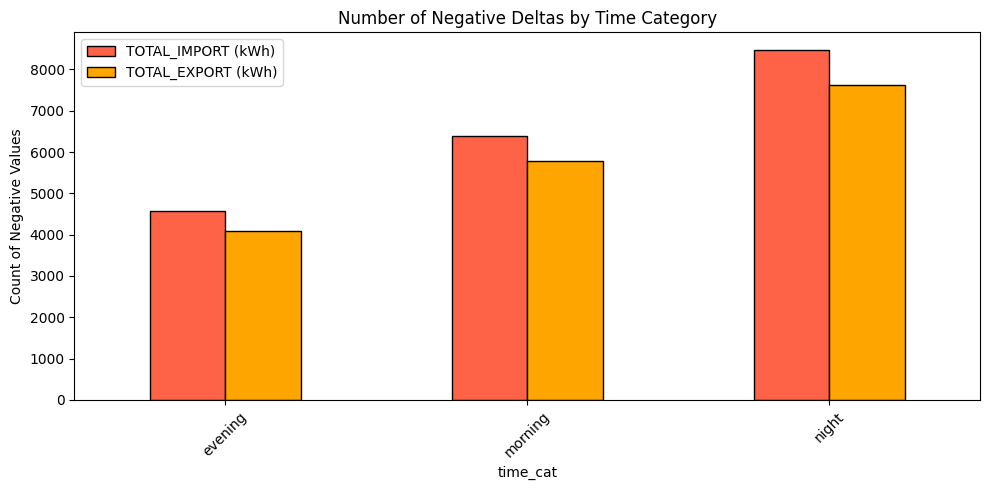

In [8]:
negatives = all_data_filtered[
    (all_data_filtered['TOTAL_IMPORT (kWh)'] < 0) |
    (all_data_filtered['TOTAL_EXPORT (kWh)'] < 0)
]

neg_counts = negatives.groupby('time_cat')[['TOTAL_IMPORT (kWh)', 'TOTAL_EXPORT (kWh)']].apply(
    lambda df: (df < 0).sum()
)

neg_counts.plot(kind='bar', figsize=(10, 5), color=['tomato', 'orange'], edgecolor='black')
plt.title("Number of Negative Deltas by Time Category")
plt.ylabel("Count of Negative Values")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### close to 20K negative TOTAL_IMPORT? That’s interesting lets try to explore whats actually happenning under the hood by examining single househods

In [9]:
negatives

,household_ID,DATETIME,Hour,Minute,time_cat,TOTAL_IMPORT (kWh),TOTAL_EXPORT (kWh)
3001693,ID0066,2023-09-21 18:38:28,18,38,evening,-13980.1620,-32494.213
917241,ID0232,2024-08-20 01:37:01,1,37,night,-0.0040,0.000
905303,ID0295,2024-08-17 01:43:10,1,43,night,-0.0040,0.000
754846,ID0457,2024-07-11 00:56:42,0,56,night,-5248.8021,735.604
755436,ID0457,2024-07-11 01:13:19,1,13,night,5250.4900,-735.604
...,...,...,...,...,...,...,...
258825,ID5569,2024-11-27 01:21:51,1,21,night,31730.0000,-33827.940
259678,ID5569,2024-11-28 01:18:22,1,18,night,-31726.1900,33835.940
260669,ID5569,2024-11-30 01:17:19,1,17,night,31760.0300,-33863.330
262038,ID5569,2024-12-01 01:20:05,1,20,night,-31755.9600,33868.800


In [10]:
# we have 154 households experiencing negative values in electricity consumption or exportation
# we explored what CSC areas has this problem frequently - it was spread throughout all the areas
# Therefore we explored what households experiencing this frequently
households = set(negatives['household_ID'])
len(households)

154

In [11]:
negative_houses = survey[survey.household_ID.isin(households)]
negative_houses.electricity_provider_csc_area.value_counts()

electricity_provider_csc_area
MORATUWA NORTH    18
PANADURA          15
NUGEGODA          12
MORATUWA SOUTH    11
KESELWATTA         7
MAHARAGAMA         5
BORALASGAMUWA      3
KALUTARA           3
DALUGAMA           2
WATTALA            1
PAYAGALA           1
Name: count, dtype: int64

In [12]:
negatives.household_ID.value_counts().head(20)

household_ID
ID4695    2699
ID4896    2475
ID5308    2450
ID5483    2247
ID5569    2221
ID4342    1718
ID1751    1671
ID0844    1625
ID5543    1605
ID4505    1579
ID3148    1566
ID1683    1515
ID5243    1477
ID3095    1452
ID4142    1345
ID3058    1074
ID5288    1040
ID2747     950
ID0551     862
ID4469     839
Name: count, dtype: int64

##### Example household 1

In [13]:
negatives[negatives['household_ID'] == 'ID0066']

,household_ID,DATETIME,Hour,Minute,time_cat,TOTAL_IMPORT (kWh),TOTAL_EXPORT (kWh)
3001693,ID0066,2023-09-21 18:38:28,18,38,evening,-13980.162,-32494.213


In [14]:
# seems like the recorded data is crashed or junk

all_data_filtered[all_data_filtered['household_ID'] == 'ID0066'].head(307)

,household_ID,DATETIME,Hour,Minute,time_cat,TOTAL_IMPORT (kWh),TOTAL_EXPORT (kWh)
3455987,ID0066,2023-02-01 01:20:14,1,20,night,NaN,NaN
3455667,ID0066,2023-02-01 06:39:40,6,39,morning,11.806,0.000
3458280,ID0066,2023-02-02 01:38:56,1,38,night,15.867,25.245
3458379,ID0066,2023-02-02 06:42:42,6,42,morning,6.598,0.000
3464945,ID0066,2023-02-03 01:43:02,1,43,night,20.756,27.289
...,...,...,...,...,...,...,...
2082793,ID0066,2023-06-08 05:36:56,5,36,morning,10.696,0.000
3001693,ID0066,2023-09-21 18:38:28,18,38,evening,-13980.162,-32494.213
3009019,ID0066,2023-09-22 00:38:54,0,38,night,8.744,0.000
3009070,ID0066,2023-09-22 05:38:36,5,38,morning,8.282,0.000


#### Removing the crashed records 

In [15]:
all_data_filtered = all_data_filtered.drop(negatives.index)

#### Density of Records

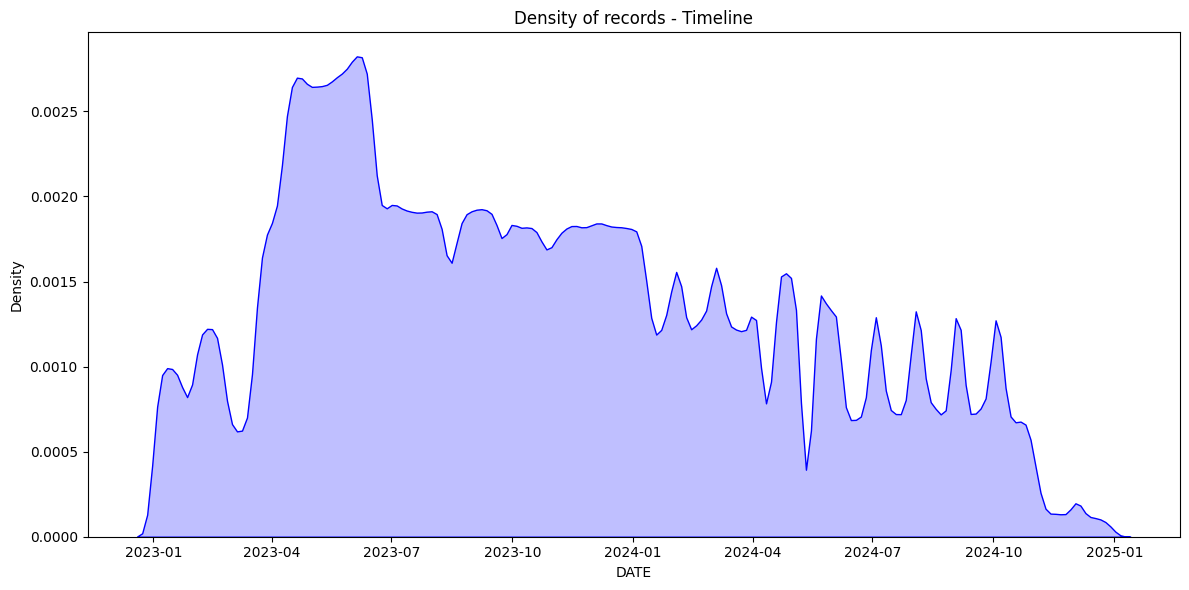

In [16]:
plt.figure(figsize=(12, 6))

sns.kdeplot(all_data_filtered['DATETIME'], fill=True, color='blue', bw_adjust=0.5)
plt.title('Density of records - Timeline')
plt.xlabel('DATE')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [17]:
# merging with survey data
merged = all_data_filtered.merge(survey, left_on=all_data_filtered.household_ID, right_on=survey.household_ID, how='left')

#### filtering the dataframe to consider a dense period of data records

In [18]:
# Method 01: using predefined time interval
start_date = '2023-04-01 00:00:00'
end_date = '2023-07-01 00:00:00'

filtered_df = merged[(merged['DATETIME'] >= start_date) & (merged['DATETIME'] < end_date)]

In [19]:
# Method 02: Using Kernel density estimation

bin_counts = merged['Hour'].value_counts(normalize=True)
# Filter bins with density > threshold
valid_bins = bin_counts[bin_counts > 0.0015].index
filtered_df = merged[merged['Hour'].isin(valid_bins)]

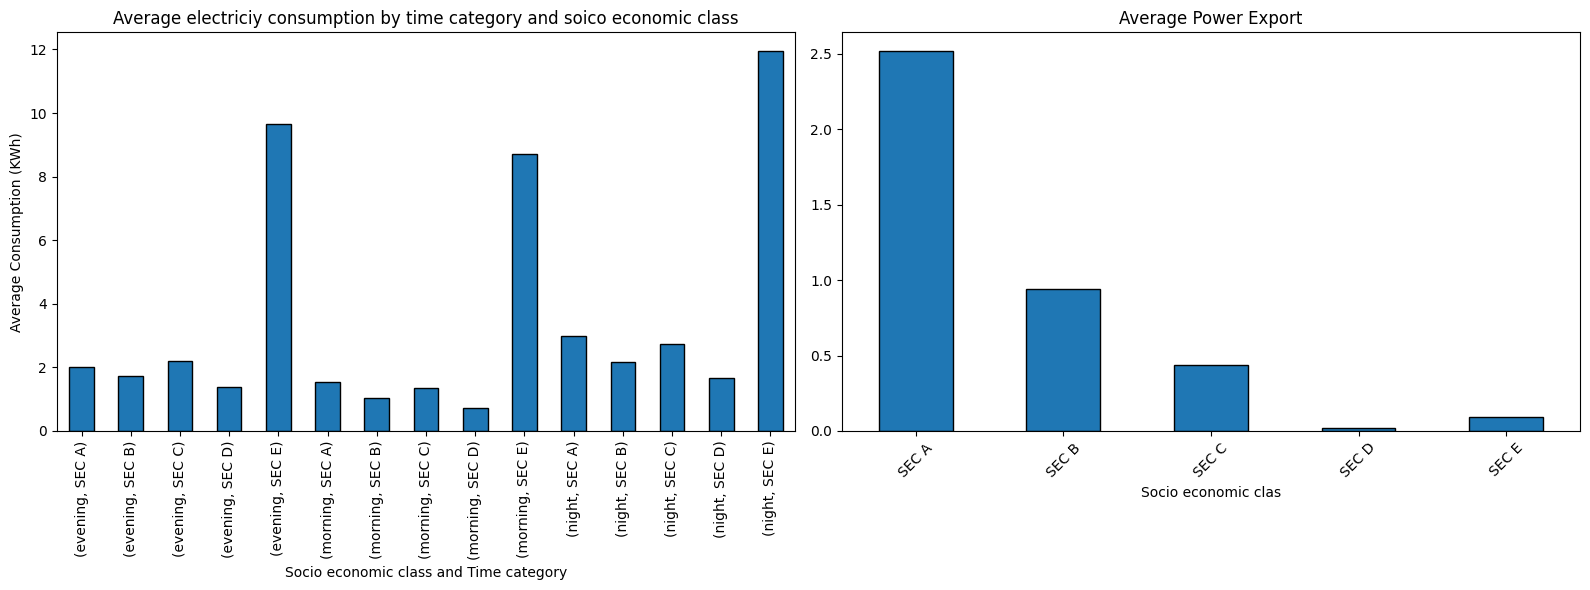

In [21]:
filtered_for_import = filtered_df[filtered_df['TOTAL_EXPORT (kWh)'] == 0]
daily_import = filtered_for_import.groupby(['time_cat', 'socio_economic_class'])['TOTAL_IMPORT (kWh)'].mean()
daily_export = filtered_df.groupby(['socio_economic_class'])['TOTAL_EXPORT (kWh)'].mean()

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

daily_import.plot(ax=ax[0], kind='bar', edgecolor='black')
ax[0].set_title("Average electriciy consumption by time category and soico economic class")
ax[0].set_xlabel('Socio economic class and Time category')
ax[0].set_ylabel('Average Consumption (KWh)')


daily_export.plot(ax=ax[1], kind='bar', edgecolor='black')
ax[1].set_title("Average Power Export")
ax[1].set_xlabel('Socio economic clas')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [29]:
class_distribution = filtered_df.groupby('socio_economic_class')['time_cat'].count()
class_distribution

socio_economic_class
SEC A    123031
SEC B    106336
SEC C    172726
SEC D     68414
SEC E     25681
Name: time_cat, dtype: int64